In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets
#!pip install cubist

In [1]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb
importing Jupyter notebook from Header.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [3]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum', 'log']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 30, 40, 50, 100]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 7. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist','svr', 'ridge', 'gbrt']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Obtaining Spectra  (Noise and Outliers removal)

In [4]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [5]:
#----------- Reading lab data, emit data and data having contaminated samples-----------------------------
df_lab = pd.read_csv('uae.csv')
df_sat = pd.read_csv('uae_emit.csv')

# #df_faulty = pd.read_csv('oil.csv')
# df_faulty = df_faulty.T
# df_faulty.columns = df_faulty.iloc[0,:].copy()
# df_faulty = df_faulty.reset_index(drop=True)
# df_faulty = df_faulty.iloc[1:, :].copy()
# df_faulty.head(5)

#-------------Renaming columns---------------------------------------------------------------------------
df_sat.rename(columns= {'latitude':'long', 'longitude': 'lat'}, inplace=True)
df_lab.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)
#df_faulty.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)

df_sat.rename(columns = {'OM': 'TOC', 'Clay': 'clay', 'Silt':'silt', 'Sand': 'sand'}, inplace = True)

In [6]:
# # obtaining faulty rows of df_lab using the data frame df_faulty ---------------------------------- 

# faulty_rows =[]
# (row, col) = df_lab.shape
# for i in range (0, row):
#     lat = df_lab.loc[i,'lat']
#     long = df_lab.loc[i,'long']
#     temp = df_faulty.loc[:,:][(df_faulty.loc[:,'lat'] == lat) & (df_faulty.loc[:,'long'] == long)]
#     (r, c) = temp.shape
#     if r != 0:
#         faulty_rows.append(i)
#         #print(r, 'at', i)

# # removing faulty rows from lab data --------------------------------------------

# clean_lab = df_lab.drop(df_lab.index[faulty_rows]).copy()

# # obtaining faulty rows of df_sat using the data frame df_faulty ---------------------------------- 

# faulty_rows =[]
# (row, col) = df_sat.shape
# for i in range (0, row):
#     lat = df_sat.loc[i,'lat']
#     long = df_sat.loc[i,'long']
#     temp = df_faulty.loc[:,:][(df_faulty.loc[:,'lat'] == lat) & (df_faulty.loc[:,'long'] == long)]
#     (r, c) = temp.shape
#     if r != 0:
#         faulty_rows.append(i)
#         #print(r, 'at', i)

# # removing faulty rows from satellite data --------------------------------------------

# clean_sat = df_sat.drop(df_sat.index[faulty_rows]).copy()

In [7]:
clean_sat = df_sat.copy()
clean_lab = df_lab.copy()

clean_sat.reset_index(drop=True)
clean_lab.reset_index(drop=True)

,FID,long,lat,TOC,clay,silt,sand,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,54.736553,24.236353,0.22,0,1.0,98.0,0.089311,0.101862,0.116344,0.117707,0.113324,0.113424,0.115095,0.110248,0.103506,0.105503,0.110169,0.112541,0.118426,0.115746,0.105909,0.107894,0.107123,0.109696,0.117092,0.117855,0.119902,0.121461,0.116911,0.112778,0.115075,0.119952,0.121716,0.123712,0.124466,0.123697,0.121629,0.121883,0.124804,0.122874,0.119764,0.123741,0.127166,0.126157,0.124842,0.123106,0.122967,0.125440,0.125761,...,0.505024,0.503972,0.503082,0.502225,0.500965,0.499482,0.498255,0.497150,0.495687,0.494069,0.492573,0.490743,0.489241,0.487959,0.486013,0.484152,0.482461,0.480586,0.478966,0.477298,0.475440,0.473770,0.471942,0.470410,0.469083,0.467510,0.466006,0.464431,0.462235,0.460467,0.459512,0.458457,0.457830,0.457056,0.455510,0.453568,0.451408,0.450124,0.449204,0.449205,0.448691,0.447846,0.446950,0.445301,0.444228,0.443859,0.443358,0.442132,0.440855,0.440254
1,2,54.712263,24.253125,0.23,0,0.0,100.0,0.071750,0.082479,0.097936,0.097098,0.090665,0.095351,0.098170,0.092902,0.085862,0.087585,0.090802,0.091751,0.100449,0.096611,0.084396,0.089818,0.089340,0.090029,0.096445,0.094647,0.095934,0.099914,0.094580,0.091928,0.096085,0.098593,0.098399,0.100215,0.103574,0.103900,0.101460,0.100196,0.101961,0.101015,0.099445,0.101963,0.103266,0.101319,0.100529,0.099800,0.100243,0.102263,0.101308,...,0.450318,0.448831,0.447116,0.445905,0.445075,0.443562,0.442045,0.440411,0.438146,0.436031,0.434178,0.431873,0.429721,0.427904,0.426066,0.424598,0.423261,0.421830,0.420088,0.417828,0.415412,0.412745,0.410257,0.408520,0.406483,0.404732,0.403398,0.401255,0.399124,0.397683,0.396048,0.394434,0.393051,0.390887,0.388737,0.387267,0.386171,0.385700,0.384558,0.383507,0.382384,0.380523,0.379745,0.379368,0.378552,0.378313,0.376914,0.375947,0.374874,0.374323
2,3,54.628437,24.201236,0.54,7,2.0,71.0,0.041403,0.053078,0.069837,0.072832,0.069875,0.074908,0.074440,0.068492,0.064969,0.060439,0.061995,0.069090,0.075366,0.072394,0.063782,0.066973,0.063572,0.064333,0.076012,0.074383,0.073874,0.076919,0.069139,0.067084,0.073654,0.077595,0.078171,0.078817,0.079354,0.078619,0.076882,0.076737,0.078894,0.078441,0.077030,0.078739,0.080757,0.080092,0.078368,0.077739,0.078954,0.081610,0.081029,...,0.254087,0.253243,0.252018,0.250617,0.249314,0.247589,0.246501,0.245682,0.244078,0.242976,0.241615,0.239750,0.238310,0.236734,0.235230,0.233702,0.232329,0.231019,0.229220,0.227910,0.226667,0.224981,0.223713,0.222331,0.220553,0.219432,0.218279,0.216748,0.215095,0.212785,0.210994,0.210149,0.209413,0.208985,0.208481,0.207685,0.206786,0.205675,0.205031,0.203774,0.202939,0.202970,0.201991,0.200577,0.199762,0.198509,0.197953,0.196985,0.196200,0.196456
3,4,54.637328,24.167353,0.06,0,1.0,74.0,0.127570,0.137622,0.152223,0.150098,0.142105,0.142880,0.146324,0.144206,0.141614,0.138125,0.138871,0.142214,0.146783,0.144006,0.135700,0.141869,0.140081,0.139891,0.145967,0.144568,0.146686,0.150084,0.145208,0.141791,0.146449,0.151923,0.151835,0.152822,0.155049,0.154900,0.152437,0.152329,0.154825,0.153069,0.150946,0.155493,0.159144,0.157156,0.154593,0.153615,0.155277,0.159256,0.158817,...,0.477536,0.476374,0.475360,0.474317,0.472941,0.471083,0.469237,0.467607,0.465895,0.464562,0.463261,0.461304,0.459077,0.456753,0.454284,0.452215,0.450451,0.448153,0.445981,0.443916,0.441472,0.439588,0.437714,0.435782,0.434151,0.432324,0.430425,0.428736,0.426160,0.423627,0.422163,0.420034,0.418287,0.417215,0.415542,0.414107,0.413113,0.412229,0.411363,0.410837,0.410158,0.409710,0.408636,0.406409,0.405014,0.403905,0.403292,0.403064,0.402813,0.401774
4,5,54.871967,24

In [8]:
# obtaining corresponding rows of clean_sat using clean_lab and removing extra rows -------------- 

missing_rows =[]

(row, col) = clean_sat.shape
small_lab = clean_lab.iloc[0:row,:].copy()

for i in range (0, row):
    lat = clean_sat.iloc[i, clean_sat.columns.get_loc('lat')]
    long = clean_sat.iloc[i, clean_sat.columns.get_loc('long')]
    temp = clean_lab.loc[:,:][(clean_lab.loc[:,'lat'] == lat) & (clean_lab.loc[:,'long'] == long)]
    (r, c) = temp.shape
    if r == 0:
        #print('missing:', i)
        missing_rows.append(i)
        #print(r, 'at', i)
    else:
        #print(i)
        small_lab.iloc[i,:] = temp.iloc[0, :].copy()
        

small_lab = small_lab.drop(small_lab.index[missing_rows]).copy()
small_sat = clean_sat.drop(clean_sat.index[missing_rows]).copy()
#small_sat.rename(columns = {'OM': 'TOC', 'Clay': 'clay', 'Silt':'silt', 'Sand': 'sand'}, inplace = True)
small_lab.reset_index()
small_sat.reset_index()
small_lab.shape

(83, 2158)

## Extracting spectra from small_sat and small_lab

In [9]:
min_loc_sat = small_sat.columns.get_loc('field_30')
max_loc_sat = small_sat.columns.get_loc('field_312')
small_sat_spec = small_sat.iloc[:, min_loc_sat: max_loc_sat+1].copy()
print(small_sat_spec.shape)

min_loc_lab = small_lab.columns.get_loc('380')
max_loc_lab = small_lab.columns.get_loc('2500')
small_lab_spec = small_lab.iloc[:, min_loc_lab: max_loc_lab].copy()
print(small_lab_spec.shape)

(83, 283)
(83, 2120)


### Resampling small_lab_spec into 283 bands

In [13]:
sampled_lab_spec = resample_spectra(small_lab_spec, 283)
sampled_lab_spec.shape

(83, 283)

### Renaming columns of sampled_sat_spec using columns of sampled_lab_spec

In [14]:
header = list(sampled_lab_spec.columns.values)
sampled_sat_spec = small_sat_spec.copy()
sampled_sat_spec.columns = header
sampled_sat_spec.shape

(83, 283)

### Obtaining faulty bands using sampled_sat_spec

<AxesSubplot:>

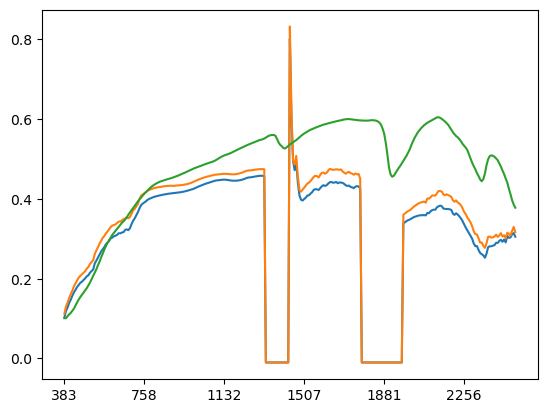

In [19]:
for i in range (0,2,1):
    sampled_sat_spec.iloc[i,:].plot()
sampled_lab_spec.iloc[1,:].plot()

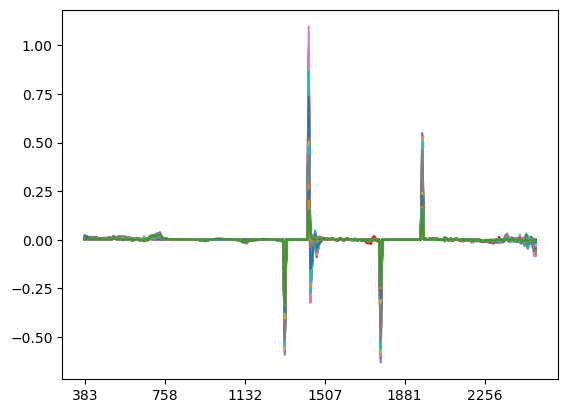

In [23]:
fod_sat = fod(sampled_sat_spec)
fod_sat
for i in range (0,83,1):
    fod_sat.iloc[i,:].plot()

,1320,1432,1440,1447,1769,1964
1,-0.484533,0.842585,-0.20953,-0.126529,-0.461067,0.370448


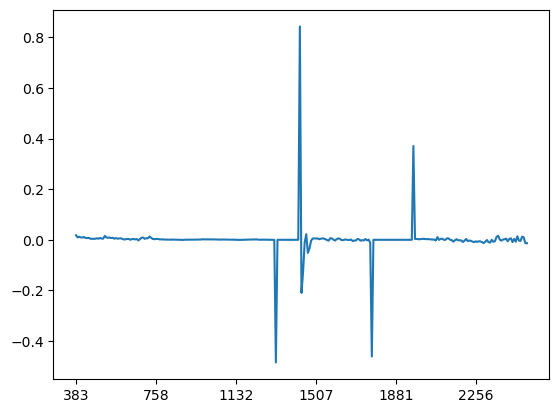

In [53]:
fod_sat.iloc[1,:].plot()

fod_sat1 = fod_sat.iloc[[1],:].copy()
b_col = (abs(fod_sat1) >=0.1).any()
fod_sat1 = fod_sat1.loc[: , b_col]
fod_sat1
#fod_sat1.columns.get_loc('1440')

In [59]:
#sampled_sat_spec.columns.get_loc('1769')

185

### Dropping faulty bands from sampled_sat_spec and sampled_lab_spec

In [55]:
# Select faulty column based on condition (i,e. boundary columns-- [1320/125:1447/142] + [1769/185:1964/211])-
faulty_columns = list(np.arange(125,143,1)) + list(np.arange(185,212,1))
print(faulty_columns)

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]


In [51]:
sat_spec = sampled_sat_spec.drop(sampled_sat_spec.columns[faulty_columns], axis=1).copy()
lab_spec = sampled_lab_spec.drop(sampled_lab_spec.columns[faulty_columns], axis=1).copy()

## Setting the "spectra" for future computations

In [52]:
spectra = sat_spec.copy()
spectra.shape

(83, 235)

# Step 1b: Obtaining Targets (Outliers removal and Normalization)

In [16]:
df = small_sat
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 


def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


# Step 1c: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

## Savgol smoothing (order 1 and order 2)

In [17]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')                   

spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')

smth_spec = sgsmooth (spectra, 3)    

## First Order Derivative

In [18]:
fod_spec = fod(smth_spec)

# for i in range (0,5,1):
#     fod_spec.iloc[i,:].plot()


## Continuum Removal

In [19]:
cr_spec = continuum_removed(spec2[51])

# for i in range (0,5,1):
#     cr_spec.iloc[i,:].plot()
    

## 1/logR Transformation

In [20]:
log_spec = ((1/spec2[51]).apply(np.log)).copy()
log_spec.head(5)

,383,391,398,406,413,421,428,436,443,451,458,466,473,481,488,496,503,511,518,526,533,541,548,556,563,571,578,586,593,600,608,615,623,630,638,645,653,660,668,675,683,690,698,705,713,720,728,735,743,750,...,2129,2136,2144,2151,2159,2166,2174,2181,2189,2196,2204,2211,2219,2226,2234,2241,2249,2256,2264,2271,2279,2286,2293,2301,2308,2316,2323,2331,2338,2346,2353,2361,2368,2376,2383,2391,2398,2406,2413,2421,2428,2436,2443,2451,2458,2466,2473,2481,2488,2496
0,2.272267,2.125367,2.055245,1.969713,1.913840,1.847595,1.795623,1.758469,1.716183,1.690557,1.660143,1.647395,1.623996,1.604516,1.579048,1.566843,1.536484,1.517682,1.499646,1.432782,1.404010,1.373046,1.342689,1.315389,1.294333,1.274727,1.249184,1.236013,1.221070,1.199603,1.192989,1.182631,1.177825,1.170818,1.157704,1.159387,1.151878,1.149535,1.131509,1.127916,1.133883,1.118813,1.087627,1.062602,1.045287,1.023042,1.001559,0.975569,0.955232,0.945692,...,0.969469,0.963494,0.958837,0.962482,0.978107,0.980033,0.981403,0.981138,0.983581,0.987108,1.013336,1.021120,1.010185,1.019673,1.031610,1.046215,1.065156,1.089373,1.113985,1.135221,1.157933,1.177489,1.202083,1.243277,1.266680,1.265915,1.301054,1.329460,1.341256,1.352520,1.375738,1.336474,1.276351,1.268223,1.267553,1.262251,1.258113,1.237376,1.238347,1.221058,1.211819,1.228612,1.209609,1.234241,1.179143,1.195579,1.192089,1.166402,1.156397,1.186197
1,2.184843,2.037334,1.966603,1.884530,1.822819,1.769737,1.706699,1.667761,1.631048,1.594119,1.573073,1.554916,1.536385,1.517626,1.490072,1.471625,1.439758,1.419847,1.400732,1.339575,1.304547,1.276134,1.244380,1.220712,1.194431,1.180251,1.157740,1.143774,1.127088,1.109270,1.098259,1.094825,1.089337,1.078716,1.068953,1.068733,1.060250,1.051569,1.046573,1.037917,1.045260,1.036885,1.014256,0.990352,0.979935,0.963348,0.947643,0.914675,0.895707,0.887775,...,0.880786,0.867593,0.867485,0.870588,0.888428,0.892782,0.887350,0.892326,0.896843,0.903195,0.924974,0.933736,0.925006,0.938397,0.945515,0.956912,0.975988,1.000246,1.016633,1.040408,1.056053,1.075026,1.103004,1.142092,1.165310,1.167900,1.198277,1.235091,1.235082,1.262828,1.282657,1.241989,1.187266,1.183907,1.194608,1.191225,1.184348,1.169473,1.187742,1.176178,1.157253,1.185115,1.173616,1.198609,1.153735,1.162968,1.177500,1.138580,1.108776,1.150018
2,2.528884,2.365131,2.221108,2.139193,2.065459,2.001001,1.933737,1.882855,1.828456,1.797865,1.770163,1.750795,1.727658,1.697558,1.674172,1.653231,1.619134,1.599474,1.580792,1.516834,1.484357,1.457554,1.423522,1.390600,1.367205,1.352614,1.314384,1.291631,1.283320,1.260582,1.267099,1.260268,1.253630,1.244730,1.232675,1.229584,1.221782,1.214788,1.211094,1.203516,1.209188,1.208179,1.194598,1.184712,1.181787,1.173704,1.172194,1.155801,1.150754,1.144643,...,1.170757,1.158313,1.158581,1.166520,1.170979,1.169980,1.177054,1.180008,1.187606,1.197715,1.211814,1.226403,1.225437,1.245796,1.246248,1.262967,1.281668,1.309350,1.326603,1.337548,1.361371,1.375237,1.404967,1.433116,1.454959,1.459626,1.486145,1.522313,1.543681,1.570164,1.603381,1.570249,1.554814,1.571050,1.570719,1.566469,1.559716,1.584468,1.590179,1.550491,1.525793,1.582101,1.577655,1.598151,1.469430,1.509526,1.507321,1.469925,1.469174,1.501813
3,2.176335,2.061038,1.963667,1.899588,1.832476,1.774473,1.725505,1.674130,1.629740,1.591135,1.569935,1.548777,1.535854,1.506385,1.481598,1.459920,1.434655,1.411539,1.394374,1.329297,1.301251,1.272487,1.240092,1.211481,1.186995,1.167022,1.140269,1.125503,1.111425,1.090502,1.085330,1.078966,1.076910,1.069314,1.056146,1.048298,1.044555,1.044467,1.038245,1.025463,1.033676,1.032359,1.020237,1.010525,1.004034,1.003999,1.006113,0.989082,0.977153,0.973071,...,0.925827,0.918934,0.919024,0.924266,0.932370,0.944922,0.939650,0.945911,0.954914,0.968158,0.982645,0.995861,0.996927,1.008147,1.020689,1.031567,1.055304,1.078249,1.097939,1.114792,1.139078,1.162517,1.188644,1.238823,1.263920,1.267376,1.299820,1.340861,1.341366,1.355192,1.393498,1.337876,1.306231,1.296858,1.280831,1.290676,1.297942,1.280193,1.274981,1.254858,1.274626,1.

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [21]:
sampled_spec = {}
for n in nbands_sampling:
    sampled_spec[n] = resample_spectra (spec2[51], n)

In [22]:
# for i in range (0,5,1):
#     sampled_spec[200].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [23]:
sampled_cr = {}
for n in nbands_sampling:
    sampled_cr[n] = resample_spectra (cr_spec, n)

In [24]:
# for i in range (0,5,1):
#     sampled_cr[200].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [25]:
sampled_fod = {}
for n in nbands_sampling:
    sampled_fod[n] = resample_spectra (fod_spec, n)

In [26]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## 4. Sampled Log (sampled_log)

In [27]:
sampled_log = {}
for n in nbands_sampling:
    sampled_log[n] = resample_spectra (log_spec, n)

In [28]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [29]:
row, col = spectra.shape

def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = fod_spec.iloc[sample,:]*10
        
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, row,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=41, description='sample', max=83), Dropdown(description='process', optio…

<function __main__.plot_spec(sample, process)>

## Correlation between wavelengths and Targets

In [30]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(fod_spec, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.7, 0.7])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)



interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [31]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.20

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For sand :test size = 0.2 	 min bin error= 20.0 	 at randome state = 34
For silt :test size = 0.2 	 min bin error= 10.0 	 at randome state = 25
For clay :test size = 0.2 	 min bin error= 10.0 	 at randome state = 20
For TOC :test size = 0.2 	 min bin error= 10.0 	 at randome state = 0
After Normalization:
For sand :test size = 0.2 	 min bin error= 20.0 	 at randome state = 34
For silt :test size = 0.2 	 min bin error= 20.0 	 at randome state = 25
For clay :test size = 0.2 	 min bin error= 10.0 	 at randome state = 20
For TOC :test size = 0.2 	 min bin error= 15.0 	 at randome state = 30


# Step 3: Parameters for Best Model Fit 

## PLSR

In [32]:
from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
#     r2L = []
#     rpdL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = find_iqrp(y_pred, y_test)
#         r2_test = find_r2(y_pred, y_test)         
#         rpd_test = find_rpd(y_pred, y_test)
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
                
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
#     R2 = max(r2L)     
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
    #print('IQRP :', IQRP,  'R2 :', R2,  '>>> n_comp: ', n_iqrp)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [33]:
import os
os.system('say "M Tree bulding about to start"')
import time

In [34]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [35]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    Y = tree[t][tp][n][p]
                    
                        
                    #------ setting spec to appropriate (sampled) spectra----
                    if p == 'none':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                spec = spec2[51]
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_spec[n]
                        
                    elif p == 'fod':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                spec = fod_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_fod[n]
                                
                    elif p == 'continuum':  
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                spec = cr_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_cr[n]
                            
                    else: 
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_log[100]
                            else:
                                spec = log_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_log[n]
                        
                        
                    #---- target selection and normalization ---
                    if tp == 'none':
                        y = T[target_names.index(t)]
                        rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                    else:
                        y = NT[target_names.index(t)]
                        rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                        #print('one more target set')
                            
                    #---- performing train-test split----------------------
                    X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                        
                        
                    #------INITIATING the appropriate models-----------------------------------------------
                    #----- PLSR: best parameters, fitting, and prediction
                    if m == 'plsr':
                        n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                        Y['n_comp'] = n_com
                        Model = PLSRegression(n_components=n_com, scale=True)
                    #----- MULTILINEAR:  fitting, and prediction---------- 
                    elif m == 'mult':
                        Model = linear_model.LinearRegression()    
                    #----- RANDOM_FOREST:   fitting, and prediction---------- 
                    elif m == 'randomforest': 
                        Model = RandomForestRegressor(random_state= 23)    
                    #----- CUBIST REGRESSION:    fitting and prediction---------
                    elif m == 'cubist':
                        Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)    
                    #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                    elif m == 'svr': 
                        Model = SVR()
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                    elif m == 'ridge': 
                        Model = KernelRidge()
                    #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                    else: 
                        Model = GradientBoostingRegressor()                         
                        
                    Model.fit(X_train, y_train)
                    y_pred = Model.predict(X_test)
                    yhat_pred = Model.predict(X_train)
                                
                    Y['test'] = y_test
                    Y['testP'] = y_pred
                    Y['train'] = y_train
                    Y['trainP'] = yhat_pred
                    Y['iqrp_test'] = find_iqrp(y_pred, y_test)
                    Y['r2_test'] = find_r2(y_pred, y_test)
                    Y['rpd_test'] = find_rpd(y_pred, y_test)
                    Y['rmse_test'] = find_rmse(y_pred, y_test)
                                                                
                                                                         
    end = time.time()                            
    os.system('say "M Tree has been built for one more method"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Loading the saved Mtree

In [55]:
with open ('uae_sampled_sat.pickle', 'rb') as file:
    Mtree = pickle.load(file)

## Mtree initialisation (do not run below code every time)

In [56]:
#Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [57]:
#Mtree['plsr'] = build_tree_for ('plsr')

### Multiple Linear Regression Branch

In [58]:
#Mtree['mult'] = build_tree_for ('mult')


### Random Forest Branch

In [59]:
#Mtree['randomforest'] = build_tree_for ('randomforest')

### SVM Branch

In [60]:
#Mtree['svr'] = build_tree_for ('svr')

### GBRT Branch

In [61]:
#Mtree['gbrt'] = build_tree_for ('gbrt')

### Ridge Regression Branch

In [62]:
#Mtree['ridge'] = build_tree_for ('ridge')

### Cubist Branch

In [63]:
#Mtree['cubist'] = build_tree_for ('cubist')

## Best of all worlds

In [64]:
ml_methods = ['mult', 'plsr', 'randomforest','svr', 'ridge', 'gbrt']

In [65]:
def best_model_parameters (Mtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for n in nbands_sampling:
            for p in prepare_spec:
                Y = Mtree[m][t][tp][n][p]
                    
                if scorer == 'iqrp':
                    cur_score = Y['iqrp_test']
                elif scorer == 'rpd':
                    cur_score = Y['rpd_test']
                else:
                    cur_score = Y['r2_test']  
                    
                if cur_score > best_score:
                    best_score = cur_score
                    best_tp = tp
                    best_n = n
                    best_p = p
                    if m == 'plsr':
                        best_n_comp = Y['n_comp']
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands:', best_n, 'Tar:', best_tp]                                 
    return (param_list)                                
    

In [66]:
def best_score_for (Mtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_model_parameters (Mtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [67]:
best_score_for(Mtree, 'sand', 'iqrp')

For:sand-> ['iqrp', 2.06, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'minmax'] :mult
For:sand-> ['iqrp', 2.05, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'minmax'] :plsr
For:sand-> ['iqrp', 2.14, 'Spec:', 'continuum', 'bands:', 40, 'Tar:', 'none'] :randomforest
For:sand-> ['iqrp', 1.83, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'minmax'] :svr
For:sand-> ['iqrp', 1.67, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:sand-> ['iqrp', 2.26, 'Spec:', 'fod', 'bands:', 50, 'Tar:', 'none'] :gbrt


In [68]:
best_score_for(Mtree, 'sand', 'r2')

For:sand-> ['r2', 0.4, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'none'] :mult
For:sand-> ['r2', 0.4, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'minmax'] :plsr
For:sand-> ['r2', 0.44, 'Spec:', 'continuum', 'bands:', 40, 'Tar:', 'none'] :randomforest
For:sand-> ['r2', 0.24, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'minmax'] :svr
For:sand-> ['r2', 0.09, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:sand-> ['r2', 0.5, 'Spec:', 'fod', 'bands:', 50, 'Tar:', 'none'] :gbrt


In [69]:
best_score_for(Mtree, 'TOC', 'iqrp')

For:TOC-> ['iqrp', 1.14, 'Spec:', 'fod', 'bands:', 20, 'Tar:', 'minmax'] :mult
For:TOC-> ['iqrp', 1.14, 'Spec:', 'continuum', 'bands:', 100, 'Tar:', 'minmax'] :plsr
For:TOC-> ['iqrp', 1.14, 'Spec:', 'fod', 'bands:', 40, 'Tar:', 'minmax'] :randomforest
For:TOC-> ['iqrp', 1.03, 'Spec:', 'fod', 'bands:', 50, 'Tar:', 'minmax'] :svr
For:TOC-> ['iqrp', 1.08, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:TOC-> ['iqrp', 1.11, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'minmax'] :gbrt


In [70]:
best_score_for(Mtree, 'TOC', 'r2')

For:TOC-> ['r2', 0.35, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'none'] :mult
For:TOC-> ['r2', 0.39, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'none'] :plsr
For:TOC-> ['r2', 0.42, 'Spec:', 'log', 'bands:', 10, 'Tar:', 'none'] :randomforest
For:TOC-> ['r2', 0.26, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'none'] :svr
For:TOC-> ['r2', 0.36, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'none'] :ridge
For:TOC-> ['r2', 0.38, 'Spec:', 'none', 'bands:', 5, 'Tar:', 'none'] :gbrt


## Plotting Model Accuracy (ipywidgets)

In [71]:
def plot_model_acc (target, target_preprocessing, spec_preprocessing, n_bands, method):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    Y = Mtree[m][t][tp][n][p]
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']
    
    iqrp_train = find_iqrp(yhat_pred, y_train)
    r2_train = find_r2(yhat_pred, y_train)
    rpd_train = find_rpd(yhat_pred, y_train)
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    return    

In [72]:
ipywidgets.interact(plot_model_acc, target = target_names,target_preprocessing = prepare_target, \
                    method = ml_methods, spec_preprocessing = prepare_spec, n_bands = nbands_sampling)

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_model_acc(target, target_preprocessing, spec_preprocessing, n_bands, method)>

## Saving the Mtree

In [53]:
# with open ('uae_sampled_sat.pickle', 'wb') as file:
#     pickle.dump(Mtree, file)